In [5]:
%load_ext autoreload
%autoreload 2

# Imports

In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.evaluation.metrics import aggregate_scores, calculate_scores
from src.data.data_loading import load_config
from src.data.code_processor import parse_code

In [17]:
# Set plot style
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
#%config InlineBackend.figure_format = 'retina'
# Set color palette
sns.set_palette('Paired')
sns.set_context('notebook')

# Set working directory

In [8]:
# set working directory to project root - EXECUTE ONLY ONCE or RESTART KERNEL
os.chdir('..')
os.getcwd()

'C:\\Users\\merti\\PycharmProjects\\cadenza-playwright-llm'

# Load data + config

In [9]:
config = load_config(config_path='config/config.yaml')

# Scoring
Metrics implemented and used in this project (see `src/evaluation/metrics.py`):
* **Weighted BLEU** $ \in [0.0, 1.0] $: The BLEU score proposed by [Papineni et al. (2002)](https://aclanthology.org/P02-1040.pdf) [1], [2] is a metric that measures the similarity between two sequences of text. The weighted BLEU score is a variant implementd in this project that uses a weighted average of the BLEU scores of the precondition part and the actual generated additional part in teh generated test script. The weights are defined in the configuration file `config/config.yaml`.
* **Success Rate** $ \in [0.0, 1.0] $: The success rate is the proportion of generated test scripts that run successfully, no matter if they are semantically correct or not.
* **Levenshtein Distance** $ d(s, t) \in \mathbb{N} $: The Levenshtein distance between strings $ s $ and $ t $ is an integer that measures the minimum number of single-character edits (insertions, deletions, or substitutions) required to change $ s $ into $ t $.

**Manual Evaluation**
First we are going to test the core functionality of the scoring functions by defining some example test cases and running the scoring functions on them.

In [10]:
# Define example test cases
test_cases = [
    {
        'generated_code': parse_code(config['paths']['prediction_dir']+'/1_2.pred.ts'),
        'validation_code': parse_code(config['dataloading']['test_script_dir']+'/1_2.spec.ts'),
        'precondition_code': parse_code(config['dataloading']['test_script_dir']+'/1_1.spec.ts')
    },
    {
        'generated_code': parse_code(config['paths']['prediction_dir']+'/2_2.pred.ts'),
        'validation_code': parse_code(config['dataloading']['test_script_dir']+'/2_2.spec.ts'),
        'precondition_code': parse_code(config['dataloading']['test_script_dir']+'/2_1.spec.ts')
    }
]

In [12]:
# Run scoring for test cases
scores = calculate_scores(test_cases)
scores

{'weighted bleu': [0.4912019643332622, 0.3995064945165301],
 'success rate': [None, None],
 'levenshtein distance': [0.33620689655172414, 0.2632398753894081]}

In [13]:
# Aggregate scores
agg_scores = aggregate_scores(scores)
agg_scores

2024-07-15 13:38:19 [src.evaluation.metrics:31] [WARNING] >>>> Missing success rate scores. Skipping...


{'weighted bleu': 0.4453542294248961,
 'success rate': None,
 'levenshtein distance': 0.29972338597056614}

**Automated Evaluation**
For simplicity an evaluation test script is implemented in `scripts/evaluation.py` that runs the scoring functions on all test cases available in the prediction directory defined in the configuration file `config/config.yaml`. The evaluation results are also automatically saved as a pickle file in the scoring results directory defined in the configuration file `config/config.yaml`.

In [39]:
# Run complete automated evaluation script
!python scripts/evaluation.py --config=config/config.yaml

2024-07-15 14:02:18 [__main__:22] [INFO] >>>> Calculating scores...
2024-07-15 14:02:18 [__main__:41] [INFO] >>>> Scores calculated. Aggregating...
2024-07-15 14:02:18 [src.evaluation.metrics:31] [WARNING] >>>> Missing success rate scores. Skipping...
2024-07-15 14:02:18 [__main__:43] [INFO] >>>> Aggregated scores: {'weighted bleu': 0.4453542294248961, 'success rate': None, 'levenshtein distance': 0.29972338597056614}
2024-07-15 14:02:18 [__main__:56] [INFO] >>>> Results saved to ./data/scores/eval_scores_20240715-1402.pkl


It is also possible to evaluate the test cases inside the notebook by using the evaluate_test_cases() function without running the whole script but directly calling the main function of the script:

In [38]:
# Run complete automated evaluation inside notebook
from scripts.evaluation import evaluate_test_cases
results = evaluate_test_cases(config)
results

2024-07-15 14:02:14 [scripts.evaluation:22] [INFO] >>>> Calculating scores...
2024-07-15 14:02:14 [scripts.evaluation:41] [INFO] >>>> Scores calculated. Aggregating...
2024-07-15 14:02:14 [src.evaluation.metrics:31] [WARNING] >>>> Missing success rate scores. Skipping...
2024-07-15 14:02:14 [scripts.evaluation:43] [INFO] >>>> Aggregated scores: {'weighted bleu': 0.4453542294248961, 'success rate': None, 'levenshtein distance': 0.29972338597056614}
2024-07-15 14:02:14 [scripts.evaluation:56] [INFO] >>>> Results saved to ./data/scores/eval_scores_20240715-1402.pkl


,file_id,test_case,test_step,weighted bleu,success rate,levenshtein distance
0,1_2,1,2,0.445354,None,0.299723
1,2_2,2,2,0.445354,None,0.299723


# Evaluation

In [15]:
# Load saved evaluation results
results = pd.read_pickle(config['paths']['scores_dir']+'eval_scores_20240714-1123.pkl')
results

,file_id,test_case,test_step,weighted bleu,success rate,levenshtein distance
0,1_2,1,2,0.445354,None,0.299723
1,2_2,2,2,0.445354,None,0.299723


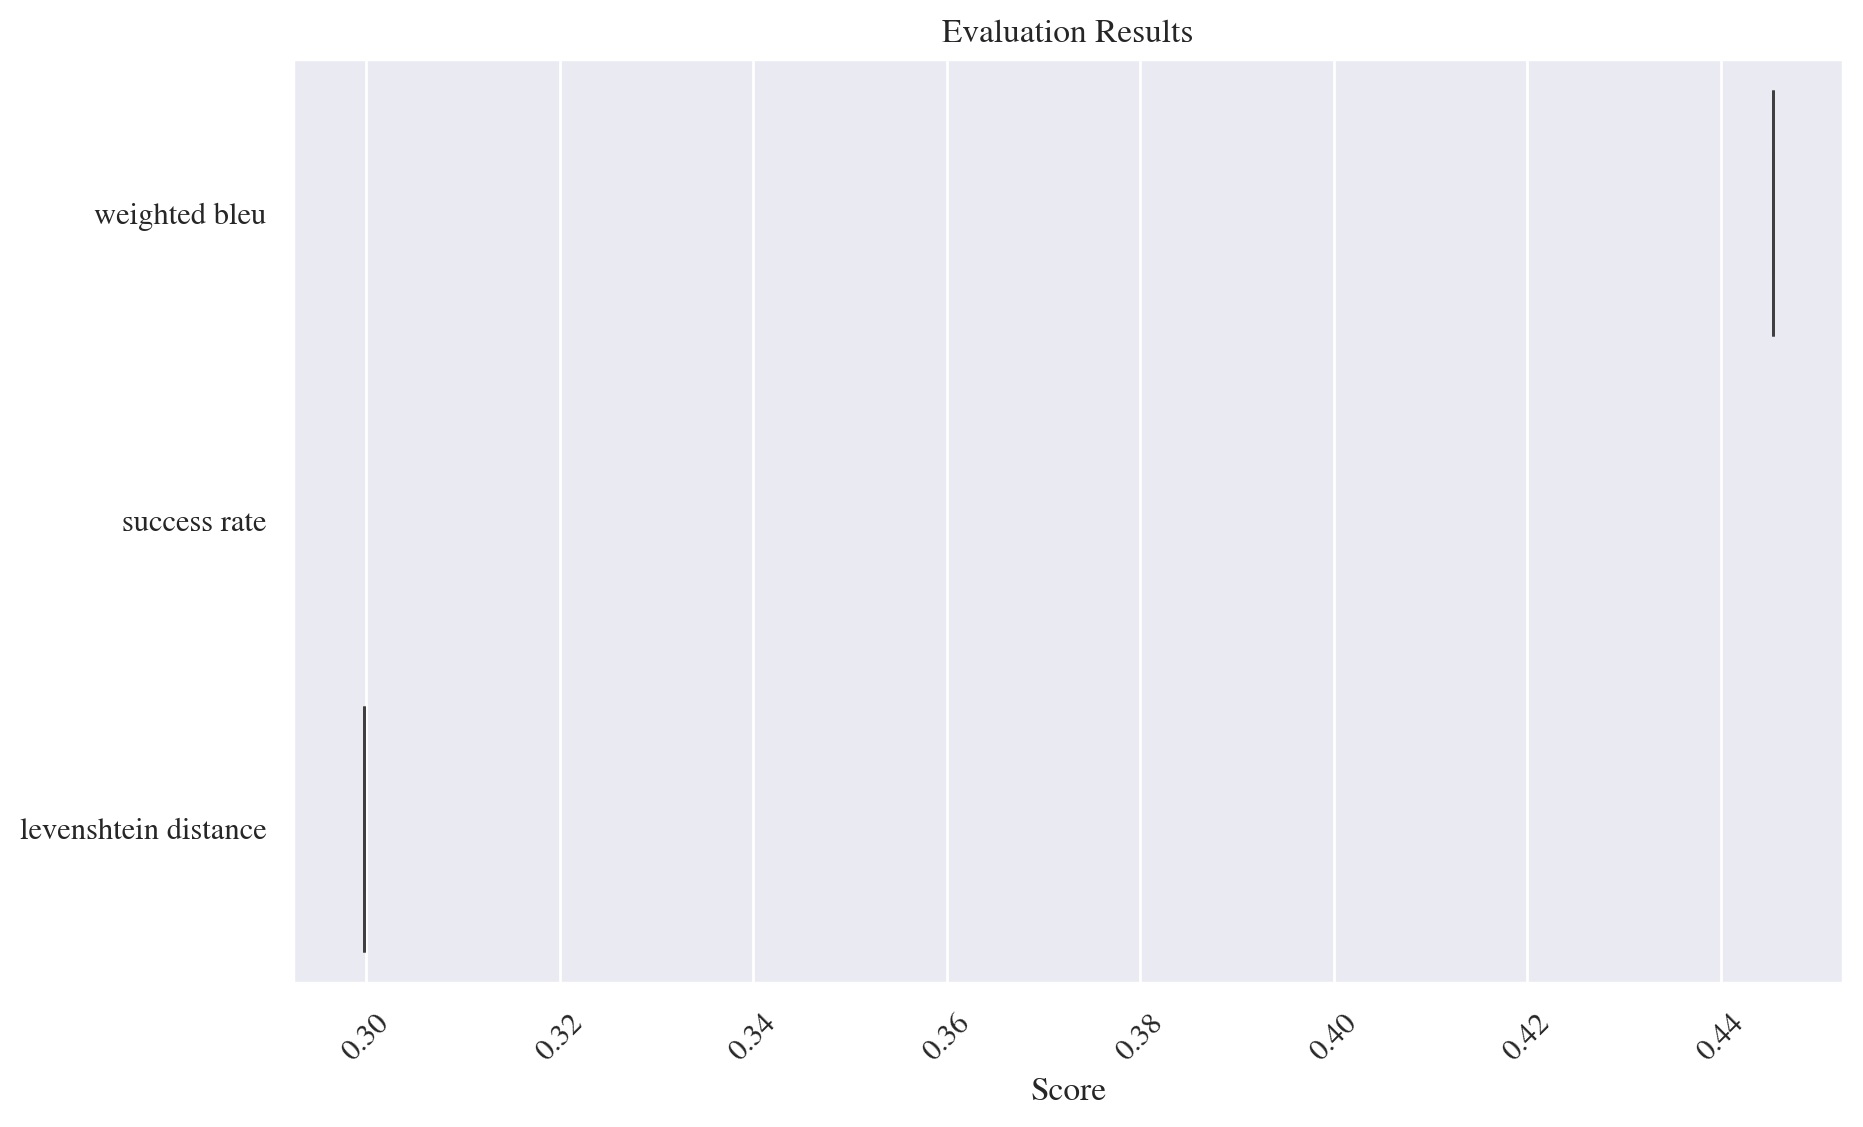

In [31]:
# Display evaluation results in a boxplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=results, ax=ax, orient='h')
ax.set_title('Evaluation Results')
ax.set_xlabel('Score')
plt.xticks(rotation=45)
plt.show()

# References
[1]
```bibtex
@INPROCEEDINGS{Papineni02bleu:a,
    author = {Kishore Papineni and Salim Roukos and Todd Ward and Wei-jing Zhu},
    title = {BLEU: a Method for Automatic Evaluation of Machine Translation},
    booktitle = {},
    year = {2002},
    pages = {311--318}
}
```
[2]
```bibtex
@inproceedings{lin-och-2004-orange,
    title = "{ORANGE}: a Method for Evaluating Automatic Evaluation Metrics for Machine Translation",
    author = "Lin, Chin-Yew  and
      Och, Franz Josef",
    booktitle = "{COLING} 2004: Proceedings of the 20th International Conference on Computational Linguistics",
    month = "aug 23{--}aug 27",
    year = "2004",
    address = "Geneva, Switzerland",
    publisher = "COLING",
    url = "https://www.aclweb.org/anthology/C04-1072",
    pages = "501--507",
}
```
